# Lab 7: Recurrent Neural Networks

## Machine learning on sequences
When performing a task on a sequence, _memory_ is often very important.
To borrow an example from [Chris Olah's excellent blog post on RNNs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) (you should probably read this!), a neural network trained to predict the next word will have trouble filling in the blank in "I grew up in France [ . . . ] I speak fluent  ____" without memory.
If it takes a fixed-size window as input, it may predict that the next word is the name of a language, but if the first sentence comes much earlier in the text, it would need to guess which language.

Another problem is how to deal with variable-length sequences.
1-D convolution is possible on a variable-length sequence, producing another variable-length sequence, but if we want to "sum up" an entire sequence as a single vector or number (for example, classifying a sentence by content), it's unclear how to do that.
Similarly, for a fixed-size input, it's unclear how we could produce a variable-sized output.
For instance, we might want to train a neural network to generate captions for images:

![image captioning RNN](./images/captioning.png)
(Image source: ["Deep Visual-Semantic Alignments for Generating Image Descriptions"](https://cs.stanford.edu/people/karpathy/deepimagesent/))

## Simple recurrent networks
These two problems suggest that we'd like to have a specialized kind of neural network for sequences, one which learns to pick out parts of the input to remember later.
This is the key idea behind a **recurrent neural network** (RNN), which maintains a **hidden state** that evolves as it reads through the input and governs how it produces output.

At every timestep $t$, a simple RNN:
 1. Reads an input $\vec{x_t}$, and computes an activation based on the input $U \vec{x_t}$ for a learned matrix $U$.
 2. Reads the previous hidden state $\vec{h_{t-1}}$, and computes an activation based on the previous hidden state $W \vec{h_{t-1}}$ for a learned matrix $W$.
 3. Computes a new hidden state for this timestep $\vec{h_t}$ by applying a nonlinearity (usually tanh) to the sum of these two activations, and a learned bias term: $\vec{h_t} = \tanh \big( \vec{b} + W \vec{h_{t-1}} + U \vec{x_t} \big )$
 4. Computes an output for this timestep $\vec{y_t}$ using the new hidden state: $\vec{y_t} = \theta(\vec{c} + V \vec{h_t})$ where $\theta$ is an appropriate activation function and $\vec{c}$ is a learned bias parameter
 
(For this formulation, see the [Deep Learning Book, Chapter 10](http://www.deeplearningbook.org/contents/rnn.html))

![RNN example](https://karpathy.github.io/assets/rnn/charseq.jpeg)
(Image source: ["The Unreasonable Effectiveness of Recurrent Neural Networks"](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy, which you should definitely also read)

Any neural network that operates over multiple timesteps, where the output or hidden state of one timestep is used as input for others, is called "recurrent".
An RNN layer that updates a hidden state in exactly this way is called a "simple RNN" -- we will introduce more complicated RNN variants later. 

tanh is the activation function of choice for producing the hidden state of simple RNNs, since it has nice properties (linearity near zero, no exploding values, not setting values to zero like ReLU) when applied repeatedly in sequence,  which we do when processing with multiple timesteps.

One view is that this forms a network with "loops", or _layers with self-connections_.
These loops allow the hidden state in one timestep $t-1$ to influence the hidden state in the next timestep $t$, with additive influence from the input at time $t$ through one regular dense layer, and another regular dense layer producing the output at time $t$.

Equivalently, RNNs can be viewed **unrolled**, where different timesteps are seen as different parts of the neural network.
In this view, every connection in an RNN is an ordinary dense layer, with the exceptions that:
 - the hidden-to-hidden layers share weights
 - the input-to-hidden layers share weights
 - the hidden-to-output layers share weights
 - the new hidden state is based on the sum of the hidden-to-hidden layer and the input-to-hidden layer, passed through an activation function

![unrolling RNNs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)
(Image source: ["Understanding LSTM Networks"](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) on Colah's blog. In this image $h$ is the output and $A$ is the hidden state.)

One neat interpretation of RNNs is that they learn to carry out an algorithm, which the elements of the hidden state acting as local variables.
In this view:
 - The input-to-hidden matrix $U$ determines how new inputs influence the local variables $h$
 - The hidden-to-hidden matrix $W$ determines how the local variables should influence each other in one step of the algorithm
 - The hidden-to-output matrix $V$ determines how the local variables should combine to produce one step of output
 
RNNs can be made deep (multi-layer) too, by adding a second recurrent layer that takes as its (variable-length) input the sequence of outputs of the first recurrent layer.

## Common structures for recurrent networks
RNNs can use their hidden state as memory, learning what to incorporate from the input ($U$), what to remember ($W$), and how to produce output based on what's remembered ($V$).

It turns out RNNs also solve our second problem with operating over sequences: they can handle arbitrary-length sequences as input or output.

![RNN structures](https://karpathy.github.io/assets/rnn/diags.jpeg)
(Image source: ["The Unreasonable Effectiveness of Recurrent Neural Networks"](https://karpathy.github.io/2015/05/21/rnn-effectiveness/))

RNNs "by default" look at one input vector and produce one output vector per timestep.
This results in a "synchronized" architecture (image 5 above), where every input is associated with an output that can also use information from previous timesteps.

However, by only taking the output vector from the last timestep, an RNN can produce a fixed-length output from a variable-sized input ("many to one").
Sentiment analysis is one example of this.
When the output vector is treated as a representation to be input to other layers in the neural network, it's interpreted as "summarizing" the sequence into a fixed-size vector.

Similarly, by only using the input vector for the first timestep, we can have an RNN produce variable-length output from a fixed-size input ("one to many").
For instance, if the input is a high-level representation learned by a convolutional network on images, we could feed this (fixed-size) vector into an RNN to produce a description of the image.
To know when to stop making new timesteps, a special "end-of-sequence" output is added to the end of every training example; when the network outputs this symbol, generation stops.

Commonly, these two ideas are combined to form a "sequence to sequence" or "encoder-decoder" model (image 4 above) in which one RNN (the "encoder") summarizes a sequence into a fixed-length vector, and the a second RNN (the "decoder") takes the fixed-length vector and produces a variable-length output sequence.
This flexible architecture enables translating between sequences of two different (arbitrary) lengths.
One obvious application is translation, though this idea's seen use in lots of places (speech-to-text, text-to-speech, video captioning, ...).

If you're curious, check out: [the paper that introduced the idea](https://arxiv.org/abs/1409.3215) and [the Keras blog's tutorial](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html).

## Backpropagation through time
RNNs are trained with a variant of backpropagation called "backpropagation through time," which, for a given training sequence, computes the gradient updates to each of the weight matrices and bias term from each timestep $t = 1, \ldots, T$ and sums them into a total update for that sequence. 

Equivalently, backpropagation through time is really just regular backpropagation applied to the unrolled computational graph.
Because the parameters $U$, $V$, $W$, and $b$ are shared across each timestep, the total gradient updates for these parameters are summed across all timesteps.

Because this unrolled computational graph is $T$ times larger than the computational graph with loops, training an RNN can often take much longer than training other kinds of networks.

For a more complete coverage of the math behind backpropagation through time (though it is really about as simple as I've said here), see [WildML's tutorial](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/) (which uses mainly words and has some sample code) or [this full derivation](https://github.com/go2carter/nn-learn/blob/master/grad-deriv-tex/rnn-grad-deriv.pdf) (which goes into more depth and uses more math).

## Long-term dependencies
There's a huge problem with simple RNNs limiting their modeling power: they have a very hard time learning long-term dependencies (for example, learning how the first word in a sentence interacts with the last word).
This is because the interaction between the input in timestep $t_1$, $x_{t_1}$, and the hidden state in timestep $t_2 >> t_1$, $h_{t_2}$, involves passing through many hidden states. 
When doing backpropagation through time, this means that these terms are the result of many matrix multiplications and passes through the tanh function.

This results in two issues that prevent simple RNNs from learning how to relate pieces of information from very different timesteps to each other.

### Exploding and vanishing gradients
Ignoring the activation function for a moment (somewhat reasonable since the tanh function looks linear for inputs near zero), these longterm interactions look like raising the hidden-hidden matrix to a high power ($t_2 - t_1$) and multiplying it by the hidden state at time $t_1$, $h_{t_1}$.

This is similar to the [power iteration algorithm in linear algebra](https://en.wikipedia.org/wiki/Power_iteration), with similar results: components of $h_{t_1}$ that are not aligned  with the largest eigenvector of $W$ decay to zero, and those that are explode to very high values.
Both of these effects happen exponentially fast.

Now considering the activation function again, the situation gets even worse.
In these long-term interactions, the gradient is passed backwards through the function that results from composing the tanh activation function many times.
A plot of this function applied to a high-dimensional hidden state reveals that it contributes to the problem of vanishing and exploding gradients (and looks very hard to optimize overall).

![repeated application of tanh](./images/repeated_tanh.png)
(Image source: the [Deep Learning Book, Chapter 10](http://www.deeplearningbook.org/contents/rnn.html))

The net result of this is that while in theory simple RNNs are able to learn to use their hidden state to remember important information for long time periods, learning this behavior with gradient descent is extremely difficult. 

### Gradient clipping
Exploding gradients are rare relative to vanishing gradients, but when they occur, gradient descent can cause the network parameters to make a large jump instead of a small step, and the optimizer needs to restart minimizing the loss from scratch.
Luckily, this has a simple and effective fix: **gradient clipping**, in which gradient updates of above a certain magnitude are "clipped" down to that magnitude, preventing large parameter jumps.
There are principled ways of picking the magnitude to clip at, but in practice 1 works well.

Gradient clipping is essential for training RNNs, but it can be helpful in training other kinds of neural networks and doesn't really come with a cost.
I use it often.

However, because vanishing gradeints are extremely common in simple RNNs, even gradient clipping does not suffice to effectively train them.

For more information on the problem of exploding and vanishing gradients, see section 10.7 in the [Deep Learning Book](http://www.deeplearningbook.org/contents/rnn.html).

In [ ]:
# Gradient clipping in TensorFlow
import tensorflow as tf

tf_opt = tf.optimizers.SGD(1e-2)
with tf.GradientTape() as g:
    loss = _loss(target, actual)
    
grads = g.gradient(loss, model.trainable_variables)
capped_grads = [tf.clip_by_norm(grad, clip_norm=1.) for grad in grads]

tf_opt.apply_gradients(capped_grads, model.trainable_variables)

# Gradient clipping in Keras
import keras
keras_opt = keras.optimizers.SGD(1e-2, clipnorm=1.)

## LSTM recurrences
One successful approach to solving the problem of vanishing gradients is "gated recurrences", of which LSTM (long short-term memory) cells are the most common.
LSTM cells, in addition to a hidden state, propagate a **cell state** between time steps which helps the gradient backpropagate with high magnitude across many time steps.

![LSTM cell](./images/lstm.png)
(Image source: ["Understanding LSTM Networks"](https://colah.github.io/posts/2015-08-Understanding-LSTMs/))

LSTMs are pretty complicated, but they're also essential for training RNNs with any kind of long-term memory.
I defer to ["Understanding LSTM Networks" on Chris Olah's blog](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) for a full explanation of how they work.

## Problems for recurrences
Despite LSTM networks trained with gradient clipping seeing lots of success on many kinds of sequence tasks (see ["
The Unreasonable Effectiveness of Recurrent Neural Networks"](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) for many good examples), the modern understanding is that these networks still don't exhibit very long term memory.

Many tasks requiring long-term memory are now performed with feedforward architectures like 1-D convolutional networks (for example, [WaveNet](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)) that use a fixed amount of context to do prediction.
[Empirical evidence](https://arxiv.org/abs/1803.01271) suggests that this fixed-size window of context is, in many cases, larger than the number of timesteps that LSTMs can in practice learn to remember things for.

See [this post by Berkely artificial intelligence research](https://bair.berkeley.edu/blog/2018/08/06/recurrent/) for full coverage of the topic.

However, all is not lost for recurrences.
They have still been successful in many tasks, including [some state of the art results](https://arxiv.org/pdf/1604.08772).
Many exciting developments, like [Neural Turing Machines](https://distill.pub/2016/augmented-rnns/), are based on recurrent layers, and many researchers think that more [advanced forms of RNNs](https://distill.pub/2016/augmented-rnns/) will lead to major breakthroughs in machine learning.
If nothing else, [they're really cool](https://distill.pub/2016/handwriting/).

## Recurrent neural networks in Keras
In Keras, recurrent layers are accomplished with [subclasses of its RNN base layer](https://keras.io/layers/recurrent/).
These are mainly:
 - `keras.layers.SimpleRNN` for a simple RNN layer (this is not often used)
 - `keras.layers.LSTM` for a layer using LSTM cells
 - `keras.layers.GRU` for a layer using gated recurrent units (GRUs), a modification of LSTM cells
 
Each of these shares a common set of parameters (see [the API documentation](https://keras.io/layers/recurrent/) for a full list):
 - `units`, the number of units to use in this layer (its width, or number of outputs)
 - If `return_sequences` is `True`, then the layer will produce an output for every input (there will be a "sequence length" axis in the output tensor). Otherwise, just the final output is considered, so the layer produces a fixed-size output.
 - If `go_backwards` is `True`, the input is processed in reverse order.

The input of an RNN layer has shape $(B, L, D)$ where $B$ is the batch size, $L$ is the sequence length (which can be `None` for variable-length sequences), and $D$ is the dimensionality of the input at each timestep.
 
#### Masking
To efficiently train RNNs, we often need to batch multiple training examples of the same length, which can mean needing padding values in the input.
Keras enables "masking", which makes RNN layers ignore timesteps used for padding (they will not affect the hidden state during the forwards pass, or gradient calculations during the backwards pass).
To do this, use an [Embedding](https://keras.io/layers/embeddings/) layer upstream and set `mask_zero` to `True` -- this will mask out 0 values in downstream RNN layers.

#### Conditioning
There are a number of ways to condition the output of an RNN on a value (for instance, to set which voice a text-to-speech system should use).
One way is to pass the constant value as part of the input as every time step.
To do this, use the `constants` keyword argument of a Keras RNN layer.

## Integrating TensorFlow and Keras
Recall from earlier that you can use TensorFlow functionality to make custom Keras layers.
The other direction is also possible: you can use Keras layers as part of a TensorFlow computational graph.
This is an all-around excellent way to build models.
It's especially useful for RNNs, since currently building them in pure TensorFlow is pretty awkward. We can extend this even further by writing our TensorFlow models as a subclass of `keras.Model`, meaning we can write fully custom Keras models. This gives us the ability to use Keras functions such as `model.fit()`.

In the Keras functional API, which we introduced in lab 5, Keras layers are functions.
Calling one of these functions on a TensorFlow tensor will return a new tensor representing its output.
When you do this, Tensors, Variables, and Operations representing this layer are automatically added to the computational graph.
Then, when you use an optimizer to minimize some loss, the variables used in this layer will also be modified.

For a full guide to writing custom Keras models with TensorFlow, see [this article from the TensorFlow documentation](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

#### Generators
As we'll see in the next example, for RNNs, our training data sequences can have variable lengths. This causes an issue when representing our data as a NumPy array, since the dimensions of axes must be equal. For example, if our training data looks like `[[1], [1, 2], [1, 2, 3]]`, we cannot convert it to a NumPy array. We could simply train our model on each sequence separately, but this would be clunky and defeat much of the purpose of Keras being a lightweight, easy-to-use framework. We can solve this problem by writing a generator function that yields batches to train on when called. We accomplish this by using the `yield` keyword in Python. You can think of this as like being able to return from a function without losing its internal state. For example,

```
def generator(n):
    i = 0
    while i < n:
        yield i
        i += 1
```

When `generator(n)` is called, it returns an iterable of `[0, 1, ..., n]`. In other words, you can think of a generator as a Pythonic way of writing an iterator. Not only does this solve our problem of providing variable length batches to our model for training, it is crucial when we deal with giant datasets that cannot be stored in memory, as they are provided by the generator as we go, rather than cached in entirety. We can pass in a generator directly into the `model.fit()` function in Keras. Note that if our generator has a `while True` loop to infinitely generate values, we need to provide a `steps_per_epoch` argument to the `model.fit()` function so we know when we have completed one epoch.

To learn more about Python generators, see this [article](https://realpython.com/introduction-to-python-generators/) and to read more about generators in Keras, see this [blog post](https://towardsdatascience.com/implementing-custom-data-generators-in-keras-de56f013581c).

## Example: Toy RNN with TensorFlow and Keras
In this example, we'll use Keras layers in a TensorFlow program to create a custom Keras model which trains a very small RNN to predict the next letter in the string "hello".

### Data
The data is structured as a list of (context, target) pairs, where the context is a variable-length list of letters and the target is a single letter.
Each letter is one-hot encoded.

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# The string to replicate.
# The ^ symbol acts as a "start of string" indicator.
# The $ symbol acts as an "end of string" indicator.
training_string = '^hello$'

# All possible symbols
dictionary = list(set(training_string))
char_index = {}
index_char = {}
for i, char in enumerate(dictionary):
    char_index[char] = i
    index_char[i] = char

n_symbols = len(dictionary)

# Generator function that continually yields (context, next letter) pairs to train on
def batch_generator(training_string):
    training_ints = [char_index[char] for char in training_string]
    training_onehot = tf.keras.utils.to_categorical(training_ints, n_symbols)
    while True:
        for i in range(1, len(training_onehot)):
            context = training_onehot[:i]
            next_letter = training_onehot[i]
            yield np.expand_dims(context, axis=0), np.expand_dims(next_letter, axis=0)

### Model
The model uses a simple RNN layer with 2 units, followed by a softmax logistic regression, to predict the next character.

In [2]:
# Dimensionality of the hidden and output spaces of the RNN
n_recurrent_units = 2

# Defining a keras model by subclassing `tf.keras.Model`
class RNN(tf.keras.Model):
    
    def __init__(self, name=None, **kwargs):
        super(RNN, self).__init__(name=name, **kwargs)
        
        self.recurrent_layer = tf.keras.layers.SimpleRNN(n_recurrent_units,
                                                         return_state=True)
        self.dense_layer = tf.keras.layers.Dense(n_symbols, activation='linear')
        
    def get_state(self, x):
        # We can access the final hidden state as a tensor
        _, state = self.recurrent_layer(x)
        return state
    
    # Called when input is passed through the model
    def call(self, x):
        feats, state = self.recurrent_layer(x)
        logits = self.dense_layer(feats)
        return tf.nn.softmax(logits)
    
optimizer = tf.optimizers.RMSprop(2e-2)

### Training loop

In [3]:
model = RNN()
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [4]:
# Since our generator infinitely yields batches, we specify `steps_per_epoch`
model.fit(batch_generator(training_string), steps_per_epoch=len(training_string) - 1, epochs=100)
model.save('./logs_lecture/model')

Epoch 1/100
6/6 [==============================] - 0s 2ms/step - loss: 1.9190
Epoch 2/100
6/6 [==============================] - 0s 2ms/step - loss: 1.7272
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 1.6288
Epoch 4/100
6/6 [==============================] - 0s 1ms/step - loss: 1.5484
Epoch 5/100
6/6 [==============================] - 0s 1ms/step - loss: 1.4777
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 1.4156
Epoch 7/100
6/6 [==============================] - 0s 1ms/step - loss: 1.3600
Epoch 8/100
6/6 [==============================] - 0s 1ms/step - loss: 1.3080
Epoch 9/100
6/6 [==============================] - 0s 1ms/step - loss: 1.2583
Epoch 10/100
6/6 [==============================] - 0s 1ms/step - loss: 1.2102
Epoch 11/100
6/6 [==============================] - 0s 1ms/step - loss: 1.1637
Epoch 12/100
6/6 [==============================] - 0s 2ms/step - loss: 1.1190
Epoch 13/100
6/6 [==============================] - 0s 1ms/st

INFO:tensorflow:Assets written to: ./logs_lecture/model/assets


### Output and hidden state visualization
We run each sub-sequence through the model, observing that it successfully predicts the next character.
This task requires memory, since the input string has a double letter in it.
Then, we plot the two dimensions of the hidden state as a function of number of timesteps when reading the input.

Context: ['^']; Predicted char: h
Context: ['^', 'h']; Predicted char: e
Context: ['^', 'h', 'e']; Predicted char: l
Context: ['^', 'h', 'e', 'l']; Predicted char: l
Context: ['^', 'h', 'e', 'l', 'l']; Predicted char: o
Context: ['^', 'h', 'e', 'l', 'l', 'o']; Predicted char: $


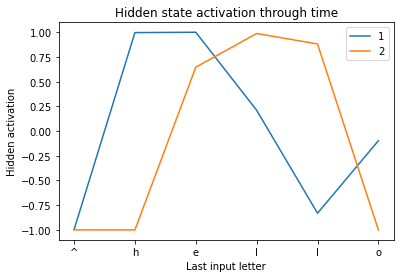

In [5]:
states = []

i = 0
for context, _ in batch_generator(training_string):
    if i == len(training_string) - 1:
        break
    pred, st = model(context), model.get_state(context)
    context_chars = [index_char[np.argmax(r)] for r in context[0]]
    pred_char = index_char[np.argmax(pred)]
    print('Context: {}; Predicted char: {}'.format(context_chars, pred_char))
    states.append(st[0])
    i += 1
states = np.array(states)

fig = plt.figure()
for i in range(n_recurrent_units):
    plt.plot(states[:, i])
plt.xticks(list(range(len(training_string) - 1)),
           training_string[:-1])
plt.xlabel('Last input letter')
plt.ylabel('Hidden activation')
plt.title('Hidden state activation through time')
plt.legend(list(range(1, n_recurrent_units + 1)))
plt.show()

### Interpreting the hidden state
The hidden state isn't always directly interpretable, but in this case both dimensions seem to track progress of the RNN through the string.
Additionally, dimension 2 has low values near the beginning and end of the string, and may help the RNN know when to stop producing "l" characters.